In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import tensorflow
import keras

In [6]:
zoom = yf.download('ZM', start='2019-12-01', end='2020-11-17', progress=False)

In [7]:
zoom.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,74.059998,74.500000,68.459999,68.930000,68.930000,3138600
2019-12-03,66.720001,70.529999,66.050003,70.019997,70.019997,2444200
2019-12-04,70.500000,70.900002,69.150002,69.959999,69.959999,2076500


In [8]:
zoom = zoom.drop(columns=['Adj Close'])

In [9]:
zoom.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-02,74.059998,74.500000,68.459999,68.930000,3138600
2019-12-03,66.720001,70.529999,66.050003,70.019997,2444200
2019-12-04,70.500000,70.900002,69.150002,69.959999,2076500


In [10]:
zoom.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [11]:
zoom.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2019-12-02 to 2020-11-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    243 non-null    float64
 1   High    243 non-null    float64
 2   Low     243 non-null    float64
 3   Close   243 non-null    float64
 4   Volume  243 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.4 KB


In [12]:
zoom.to_csv('zoom_export.csv')

Text(0, 0.5, 'Prices')

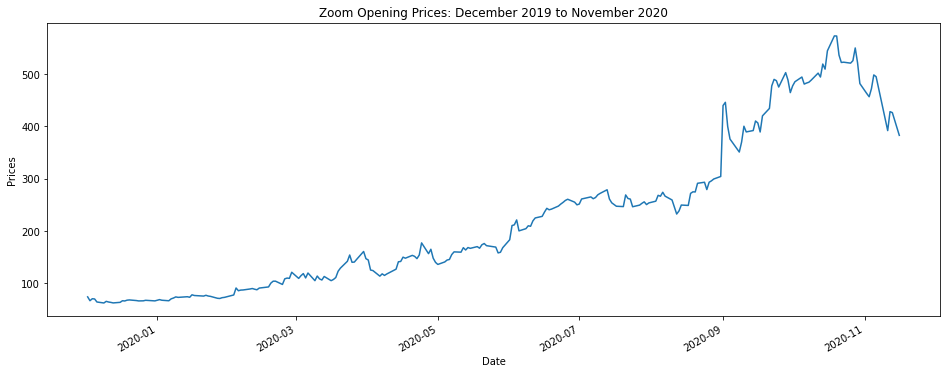

In [13]:
zoom['Open'].plot(figsize=(16,6))
plt.title('Zoom Opening Prices: December 2019 to November 2020')
plt.xlabel('Date')
plt.ylabel('Prices')

In [14]:
zoom.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2019-12-02,NaN,NaN,NaN,NaN,NaN
2019-12-03,NaN,NaN,NaN,NaN,NaN
2019-12-04,NaN,NaN,NaN,NaN,NaN
2019-12-05,NaN,NaN,NaN,NaN,NaN
2019-12-06,NaN,NaN,NaN,NaN,NaN
2019-12-09,NaN,NaN,NaN,NaN,NaN
2019-12-10,67.635714,69.265714,65.815715,67.404285,4.530757e+06
2019-12-11,66.232857,67.830000,64.900001,66.631428,4.608900e+06
2019-12-12,65.771428,66.930000,64.338572,65.555715,4.733629e+06


Text(0, 0.5, 'Price')

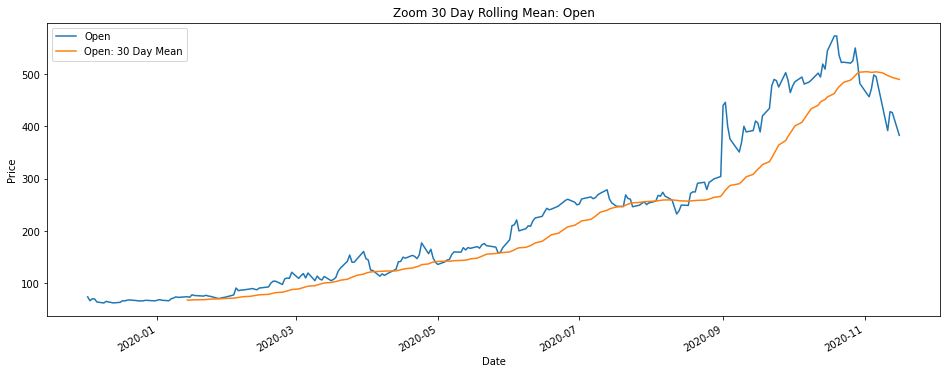

In [15]:
zoom['Open: 30 Day Mean'] = zoom['Open'].rolling(window=30).mean()
zoom[['Open','Open: 30 Day Mean']].plot(figsize=(16,6))
plt.title('Zoom 30 Day Rolling Mean: Open')
plt.ylabel('Price')

Text(0, 0.5, 'Historic Price')

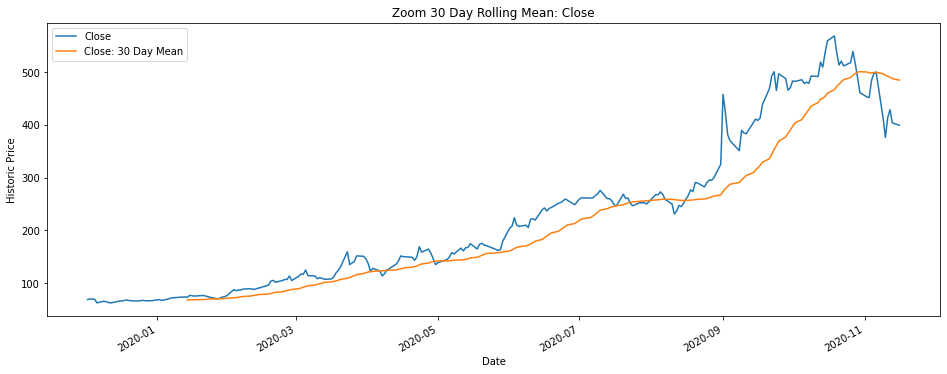

In [16]:
zoom['Close: 30 Day Mean'] = zoom['Close'].rolling(window=30).mean()
zoom[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))
plt.title('Zoom 30 Day Rolling Mean: Close')
plt.ylabel('Historic Price')

In [17]:
zoom_training_set = zoom['Close']
zoom_training_set = pd.DataFrame(zoom_training_set)

In [18]:
from sklearn.preprocessing import MinMaxScaler
zoom_scale = MinMaxScaler(feature_range = (0, 1))
zoom_training_set_scaled = zoom_scale.fit_transform(zoom_training_set)

In [19]:
X_train = []
y_train = []
for i in range(30, 223):
    X_train.append(zoom_training_set_scaled[i-30:i,0])
    y_train.append(zoom_training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [21]:
regressor = Sequential()

In [22]:
# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [66]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 300, batch_size = 96)

Epoch 1/300
3/3 [==============================] - 0s 91ms/step - loss: 0.0027
Epoch 2/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0037
Epoch 3/300
3/3 [==============================] - 0s 55ms/step - loss: 0.0027
Epoch 4/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0034
Epoch 5/300
3/3 [==============================] - 0s 56ms/step - loss: 0.0035
Epoch 6/300
3/3 [==============================] - 0s 52ms/step - loss: 0.0030
Epoch 7/300
3/3 [==============================] - 0s 52ms/step - loss: 0.0032
Epoch 8/300
3/3 [==============================] - 0s 51ms/step - loss: 0.0031
Epoch 9/300
3/3 [==============================] - 0s 70ms/step - loss: 0.0027
Epoch 10/300
3/3 [==============================] - 0s 47ms/step - loss: 0.0031
Epoch 11/300
3/3 [==============================] - 0s 45ms/step - loss: 0.0025
Epoch 12/300
3/3 [==============================] - 0s 50ms/step - loss: 0.0026
Epoch 13/300
3/3 [==============================]

In [67]:
zoom_test = pd.read_csv('zoom_test_set.csv', index_col = 'Date', parse_dates=True)

In [68]:
zoom_test.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-07,482.50000,487.500000,477.109985,480.609985,4449500
2020-10-08,484.00000,489.489990,475.579987,478.549988,4193100
2020-10-09,487.98999,498.899994,484.079987,492.410004,8719700


In [69]:
real_prc_zoom = zoom_test.iloc[:, 1:2].values

In [70]:
zoom_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2020-10-07 to 2020-11-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    29 non-null     float64
 1   High    29 non-null     float64
 2   Low     29 non-null     float64
 3   Close   29 non-null     float64
 4   Volume  29 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 1.4 KB


In [71]:
zoom_test['Volume'] = zoom_test['Volume'].astype(float)

In [72]:
zoom_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2020-10-07 to 2020-11-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    29 non-null     float64
 1   High    29 non-null     float64
 2   Low     29 non-null     float64
 3   Close   29 non-null     float64
 4   Volume  29 non-null     float64
dtypes: float64(5)
memory usage: 1.4 KB


In [73]:
zoom_test_set=zoom_test['Open']
zoom_test_set=pd.DataFrame(zoom_test_set)

In [74]:
zoom_test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2020-10-07 to 2020-11-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    29 non-null     float64
dtypes: float64(1)
memory usage: 464.0 bytes


In [75]:
zoom_total = pd.concat((zoom['Open'], zoom_test_set['Open']), axis = 0)
inputs = zoom_total[len(zoom_total) - len(zoom_test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = zoom_scale.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
zoom_predicted_stock_price = regressor.predict(X_test)
zoom_predicted_stock_price = zoom_scale.inverse_transform(zoom_predicted_stock_price)

In [76]:
zoom_predicted_stock_price=pd.DataFrame(zoom_predicted_stock_price)
zoom_predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20 non-null     float32
dtypes: float32(1)
memory usage: 208.0 bytes


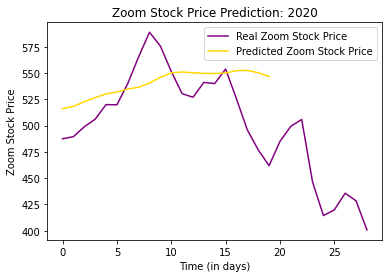

In [77]:
plt.plot(real_prc_zoom, color = 'purple', label = 'Real Zoom Stock Price')
plt.plot(zoom_predicted_stock_price, color = 'gold', label = 'Predicted Zoom Stock Price')
plt.title('Zoom Stock Price Prediction: 2020')
plt.xlabel('Time (in days)')
plt.ylabel('Zoom Stock Price')
plt.legend()
plt.show()